In [1]:
import gc
import os
import sys
import warnings
from glob import glob
import matplotlib.pyplot as plt

import albumentations as A
from albumentations.pytorch import ToTensorV2
import pandas as pd
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import segmentation_models_pytorch as smp
from torch.cuda import amp
from tqdm import tqdm

In [2]:
sys.path.append('../')
from script.metrics import *
from script.dataset import *
from script.helper import *
from script.scheduler import *
from script.loss import *

### Config

In [3]:
class CFG:
    debug = False
    # ============== comp exp name =============
    comp_name = 'contrail'
    comp_dir_path = '/kaggle/input/'
    comp_folder_name = 'google-research-identify-contrails-reduce-global-warming'

    dataset_path = "/kaggle/working/dataset_train/ash_color/"

    exp_name = os.getcwd().split('/')[-1]

    # ============== model cfg =============
    model_arch = 'Unet'
    backbone = 'timm-resnest101e'
    in_chans = 3
    target_size = 1

    # ============== training cfg =============
    train_batch_size = 32
    valid_batch_size = train_batch_size

    epochs = 90
    epochs_patience = 12

    lr = 1e-4
    loss = "DiceLoss"
    smooth=300
    
    # ============== fixed =============
    num_workers = 4
    seed = 42

    # ============== augmentation =============
    train_aug_list = [
        A.RandomRotate90(),
        A.RandomBrightnessContrast(),
        A.ShiftScaleRotate(p=0.5,rotate_limit=(10,10)),
        A.GridDistortion(num_steps=5, distort_limit=0.3, p=0.5),
        A.CoarseDropout(max_holes=10, max_width=int(256 * 0.05), max_height=int(256 * 0.05),
                        mask_fill_value=0, p=0.5),
        A.RandomGridShuffle(),
        ToTensorV2(transpose_mask=True),
    ]

    valid_aug_list = [
        ToTensorV2(transpose_mask=True),
    ]


warnings.filterwarnings("ignore")
torch.backends.cudnn.benchmark = True
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
set_seed(CFG.seed)
os.makedirs(f'./{CFG.exp_name}/', exist_ok=True)

# Dataset

In [4]:
train_df = pd.read_csv(f"{CFG.dataset_path}/train_df.csv")
valid_df = pd.read_csv(f"{CFG.dataset_path}/validation_df.csv")

if CFG.debug:
    train_df=train_df[:2000]
    valid_df=valid_df[:2000]
train_df.shape, valid_df.shape

((20529, 2), (1856, 2))

In [5]:
dataset_train = ContrailsDataset(train_df, CFG.train_aug_list)
dataset_valid = ContrailsDataset(valid_df, CFG.valid_aug_list)

dataloader_train = DataLoader(dataset_train, batch_size=CFG.train_batch_size , shuffle=True, num_workers = CFG.num_workers)
dataloader_valid = DataLoader(dataset_valid, batch_size=CFG.valid_batch_size, num_workers = CFG.num_workers)

print(f"""
{len(dataset_train) = }
train_image_shape : {dataset_train[0][0].shape}
train_mask_shape  : {dataset_train[0][1].shape}
train_image_dtype : {dataset_train[0][0].dtype}
train_mask_dtype : {dataset_train[0][1].dtype}

{len(dataset_valid) = }
valid_image_shape : {dataset_valid[0][0].shape}
valid_mask_shape  : {dataset_valid[0][1].shape}
valid_image_dtype : {dataset_valid[0][0].dtype}
valid_mask_dtype : {dataset_valid[0][1].dtype}
""")

# show_dataset(112, dataset_train)


len(dataset_train) = 20529
train_image_shape : torch.Size([3, 256, 256])
train_mask_shape  : torch.Size([1, 256, 256])
train_image_dtype : torch.float32
train_mask_dtype : torch.float32

len(dataset_valid) = 1856
valid_image_shape : torch.Size([3, 256, 256])
valid_mask_shape  : torch.Size([1, 256, 256])
valid_image_dtype : torch.float32
valid_mask_dtype : torch.float32



# Model

In [6]:
class CustomModel(nn.Module):
    def __init__(self,model_arch, backbone, in_chans, target_size, weight):
        super().__init__()

        self.model = smp.create_model(
            model_arch,
            encoder_name=backbone,
            encoder_weights=weight,
            in_channels=in_chans,
            classes=target_size,
            activation=None,
        )
        
    def forward(self, image):
        output = self.model(image)
        return output


def build_model(model_arch, backbone, in_chans, target_size, weight="imagenet"):
    print('model_arch: ', model_arch)
    print('backbone: ', backbone)
    model = CustomModel(model_arch, backbone, in_chans, target_size, weight)
    return model


num_gpus = torch.cuda.device_count()
device_ids = list(range(num_gpus))

model = build_model(CFG.model_arch, CFG.backbone, CFG.in_chans, CFG.target_size)
model = nn.DataParallel(model, device_ids=device_ids)
model.to(device);

model_arch:  Unet
backbone:  timm-resnest101e


In [7]:
scaler = amp.GradScaler()
criterion = get_lossfn(CFG, CFG.smooth)
optimizer = torch.optim.AdamW(model.parameters(), lr=CFG.lr)
scheduler = get_scheduler(CFG, optimizer)

thresholds_to_test = [round(x * 0.01, 2) for x in range(1, 101, 2)]

# Training

In [8]:
if CFG.debug:
    print("!!!Debug mode!!!\n")

dice_score=0
for epoch in range(100):
    model.train()
    
    pbar_train = enumerate(dataloader_train)
    pbar_train = tqdm(pbar_train, total=len(dataloader_train), bar_format="{l_bar}{bar:10}{r_bar}{bar:-0b}")
    loss_train, loss_val= 0.0, 0.0
    for i, (images, masks) in pbar_train:
        images, masks = images.cuda(), masks.cuda()
        optimizer.zero_grad()
        with amp.autocast():
            preds = model(images)
            loss = criterion(preds, masks)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            loss_train += loss.detach().item()
        
        lr = f"LR : {scheduler.get_last_lr()[0]:.2E}"
        gpu_mem = f"Mem : {torch.cuda.memory_reserved() / 1E9:.3g}GB"
        pbar_train.set_description(("%10s  " * 3 + "%10s") % (f"Epoch {epoch}/{CFG.epochs}", gpu_mem, lr,
                                                                f"Loss: {loss_train / (i + 1):.4f}"))

    scheduler.step()
    model.eval()
    
    cum_pred = []
    cum_true = []
    pbar_val = enumerate(dataloader_valid)
    pbar_val = tqdm(pbar_val, total=len(dataloader_valid), bar_format="{l_bar}{bar:10}{r_bar}{bar:-10b}")
    for i, (images, masks) in pbar_val:
        images, masks = images.cuda(), masks.cuda()
        with torch.no_grad():
            preds = model(images)
            loss_val += criterion(preds, masks).item()
            preds = torch.sigmoid(preds)
            cum_pred.append(preds.cpu().detach().numpy())
            cum_true.append(masks.cpu().detach().numpy())

        pbar_val.set_description(("%10s") % (f"Val Loss: {loss_val / (i+1):.4f}"))
    
    cum_pred = torch.flatten(torch.from_numpy(np.concatenate(cum_pred, axis=0)))
    cum_true = torch.flatten(torch.from_numpy(np.concatenate(cum_true, axis=0)))
    
    dice_score_, thresh = calc_optim_thresh(cum_pred, cum_true, thresholds_to_test)
    
    if dice_score_ > dice_score:
        print(f"FBeta : {dice_score_:.4f}\tthresh : {thresh}\tSAVED MODEL\n")
        epoch_best=epoch
        dice_score =dice_score_
        torch.save({'model': model.module.state_dict(), 'dice_score': dice_score, 'thresh': thresh,
                    "model_arch":CFG.model_arch, "backbone":CFG.backbone,"in_chans":CFG.in_chans,"target_size":CFG.target_size,},
                    f'./{CFG.exp_name}/{CFG.exp_name}.pth')
    else:
        print(f"FBeta : {dice_score_:.4f}\tthresh : {thresh}\n")
    
!curl -X POST -H 'Authorization: Bearer '$LINE -F 'message=セルの実行が終わりました！{dice_score}' https://notify-api.line.me/api/notify


Epoch 0/90  Mem : 10.8GB  LR : 1.00E-04  Loss: 0.7540: 100%|██████████| 642/642 
Val Loss: 0.5750: 100%|██████████| 58/58 [00:05<00:00, 11.17it/s]               


FBeta : 0.5520	thresh : 0.37	SAVED MODEL



Epoch 1/90  Mem : 10.8GB  LR : 1.00E-03  Loss: 0.5299: 100%|██████████| 642/642 
Val Loss: 0.5360: 100%|██████████| 58/58 [00:05<00:00, 10.62it/s]               


FBeta : 0.4894	thresh : 0.99



Epoch 2/90  Mem : 10.8GB  LR : 1.00E-03  Loss: 0.4880: 100%|██████████| 642/642 
Val Loss: 0.4571: 100%|██████████| 58/58 [00:05<00:00, 10.40it/s]               


FBeta : 0.5513	thresh : 0.91



Epoch 3/90  Mem : 10.8GB  LR : 1.00E-03  Loss: 0.4723: 100%|██████████| 642/642 
Val Loss: 0.4754: 100%|██████████| 58/58 [00:05<00:00, 10.56it/s]               


FBeta : 0.5379	thresh : 0.01



Epoch 4/90  Mem : 10.8GB  LR : 1.00E-03  Loss: 0.4656: 100%|██████████| 642/642 
Val Loss: 0.4909: 100%|██████████| 58/58 [00:05<00:00, 10.67it/s]               


FBeta : 0.5116	thresh : 0.03



Epoch 5/90  Mem : 10.8GB  LR : 1.00E-03  Loss: 0.4565: 100%|██████████| 642/642 
Val Loss: 0.4539: 100%|██████████| 58/58 [00:05<00:00, 10.73it/s]               


FBeta : 0.5500	thresh : 0.77



Epoch 6/90  Mem : 10.8GB  LR : 1.00E-03  Loss: 0.4526: 100%|██████████| 642/642 
Val Loss: 0.4405: 100%|██████████| 58/58 [00:05<00:00, 10.71it/s]               


FBeta : 0.5623	thresh : 0.07	SAVED MODEL



Epoch 7/90  Mem : 10.8GB  LR : 1.00E-03  Loss: 0.4475: 100%|██████████| 642/642 
Val Loss: 0.4437: 100%|██████████| 58/58 [00:05<00:00, 10.73it/s]               


FBeta : 0.5660	thresh : 0.01	SAVED MODEL



Epoch 8/90  Mem : 10.8GB  LR : 1.00E-03  Loss: 0.4414: 100%|██████████| 642/642 
Val Loss: 0.4589: 100%|██████████| 58/58 [00:05<00:00, 10.84it/s]               


FBeta : 0.5547	thresh : 0.01



Epoch 9/90  Mem : 10.8GB  LR : 1.00E-03  Loss: 0.4425: 100%|██████████| 642/642 
Val Loss: 0.4242: 100%|██████████| 58/58 [00:05<00:00, 10.83it/s]               


FBeta : 0.5888	thresh : 0.03	SAVED MODEL



Epoch 10/90  Mem : 10.8GB  LR : 1.00E-03  Loss: 0.4403: 100%|██████████| 642/642
Val Loss: 0.4246: 100%|██████████| 58/58 [00:05<00:00, 10.78it/s]               


FBeta : 0.5808	thresh : 0.11



Epoch 11/90  Mem : 10.8GB  LR : 1.00E-03  Loss: 0.4365: 100%|██████████| 642/642
Val Loss: 0.4242: 100%|██████████| 58/58 [00:05<00:00, 10.66it/s]               


FBeta : 0.5802	thresh : 0.01



Epoch 12/90  Mem : 10.8GB  LR : 1.00E-03  Loss: 0.4345: 100%|██████████| 642/642
Val Loss: 0.4298: 100%|██████████| 58/58 [00:05<00:00, 10.62it/s]               


FBeta : 0.5739	thresh : 0.01



Epoch 13/90  Mem : 10.8GB  LR : 1.00E-03  Loss: 0.4292: 100%|██████████| 642/642
Val Loss: 0.4312: 100%|██████████| 58/58 [00:05<00:00, 10.63it/s]               


FBeta : 0.5789	thresh : 0.79



Epoch 14/90  Mem : 10.8GB  LR : 1.00E-03  Loss: 0.4321: 100%|██████████| 642/642
Val Loss: 0.4038: 100%|██████████| 58/58 [00:05<00:00, 10.73it/s]               


FBeta : 0.5956	thresh : 0.11	SAVED MODEL



Epoch 15/90  Mem : 10.8GB  LR : 1.00E-03  Loss: 0.4295: 100%|██████████| 642/642
Val Loss: 0.4341: 100%|██████████| 58/58 [00:05<00:00, 10.77it/s]               


FBeta : 0.5761	thresh : 0.01



Epoch 16/90  Mem : 10.8GB  LR : 1.00E-03  Loss: 0.4249: 100%|██████████| 642/642
Val Loss: 0.4004: 100%|██████████| 58/58 [00:05<00:00, 10.73it/s]               


FBeta : 0.6034	thresh : 0.01	SAVED MODEL



Epoch 17/90  Mem : 10.8GB  LR : 1.00E-03  Loss: 0.4256: 100%|██████████| 642/642
Val Loss: 0.4015: 100%|██████████| 58/58 [00:05<00:00, 10.72it/s]               


FBeta : 0.6044	thresh : 0.03	SAVED MODEL



Epoch 18/90  Mem : 10.8GB  LR : 1.00E-03  Loss: 0.4237: 100%|██████████| 642/642
Val Loss: 0.4074: 100%|██████████| 58/58 [00:05<00:00, 10.75it/s]               


FBeta : 0.5997	thresh : 0.01



Epoch 19/90  Mem : 10.8GB  LR : 1.00E-03  Loss: 0.4205: 100%|██████████| 642/642
Val Loss: 0.3974: 100%|██████████| 58/58 [00:05<00:00, 10.79it/s]               


FBeta : 0.6063	thresh : 0.97	SAVED MODEL



Epoch 20/90  Mem : 10.8GB  LR : 1.00E-03  Loss: 0.4197: 100%|██████████| 642/642
Val Loss: 0.3996: 100%|██████████| 58/58 [00:05<00:00, 10.79it/s]               


FBeta : 0.6025	thresh : 0.25



Epoch 21/90  Mem : 10.8GB  LR : 1.00E-03  Loss: 0.4179: 100%|██████████| 642/642
Val Loss: 0.3929: 100%|██████████| 58/58 [00:05<00:00, 10.73it/s]               


FBeta : 0.6089	thresh : 0.75	SAVED MODEL



Epoch 22/90  Mem : 10.8GB  LR : 1.00E-03  Loss: 0.4152: 100%|██████████| 642/642
Val Loss: 0.4085: 100%|██████████| 58/58 [00:05<00:00, 10.71it/s]               


FBeta : 0.5982	thresh : 0.99



Epoch 23/90  Mem : 10.8GB  LR : 1.00E-03  Loss: 0.4168: 100%|██████████| 642/642
Val Loss: 0.3996: 100%|██████████| 58/58 [00:05<00:00, 10.59it/s]               


FBeta : 0.6026	thresh : 0.01



Epoch 24/90  Mem : 10.8GB  LR : 1.00E-03  Loss: 0.4140: 100%|██████████| 642/642
Val Loss: 0.3843: 100%|██████████| 58/58 [00:05<00:00, 10.81it/s]               


FBeta : 0.6166	thresh : 0.07	SAVED MODEL



Epoch 25/90  Mem : 10.8GB  LR : 1.00E-03  Loss: 0.4107: 100%|██████████| 642/642
Val Loss: 0.3929: 100%|██████████| 58/58 [00:05<00:00, 10.67it/s]               


FBeta : 0.6113	thresh : 0.91



Epoch 26/90  Mem : 10.8GB  LR : 1.00E-03  Loss: 0.4091: 100%|██████████| 642/642
Val Loss: 0.3999: 100%|██████████| 58/58 [00:05<00:00, 10.75it/s]               


FBeta : 0.6036	thresh : 0.01



Epoch 27/90  Mem : 10.8GB  LR : 1.00E-03  Loss: 0.4102: 100%|██████████| 642/642
Val Loss: 0.3946: 100%|██████████| 58/58 [00:05<00:00, 10.73it/s]               


FBeta : 0.6114	thresh : 0.99



Epoch 28/90  Mem : 10.8GB  LR : 1.00E-03  Loss: 0.4084: 100%|██████████| 642/642
Val Loss: 0.3755: 100%|██████████| 58/58 [00:05<00:00, 10.82it/s]               


FBeta : 0.6256	thresh : 0.45	SAVED MODEL



Epoch 29/90  Mem : 10.8GB  LR : 1.00E-03  Loss: 0.4090: 100%|██████████| 642/642
Val Loss: 0.3977: 100%|██████████| 58/58 [00:05<00:00, 10.80it/s]               


FBeta : 0.6076	thresh : 0.05



Epoch 30/90  Mem : 10.8GB  LR : 1.00E-03  Loss: 0.4077: 100%|██████████| 642/642
Val Loss: 0.3775: 100%|██████████| 58/58 [00:05<00:00, 10.72it/s]               


FBeta : 0.6227	thresh : 0.83



Epoch 31/90  Mem : 10.8GB  LR : 1.00E-03  Loss: 0.4060: 100%|██████████| 642/642
Val Loss: 0.3879: 100%|██████████| 58/58 [00:05<00:00, 10.77it/s]               


FBeta : 0.6151	thresh : 0.01



Epoch 32/90  Mem : 10.8GB  LR : 1.00E-03  Loss: 0.4037: 100%|██████████| 642/642
Val Loss: 0.3901: 100%|██████████| 58/58 [00:05<00:00, 10.71it/s]               


FBeta : 0.6153	thresh : 0.15



Epoch 33/90  Mem : 10.8GB  LR : 1.00E-03  Loss: 0.4055: 100%|██████████| 642/642
Val Loss: 0.3985: 100%|██████████| 58/58 [00:05<00:00, 10.81it/s]               


FBeta : 0.6097	thresh : 0.05



Epoch 34/90  Mem : 10.8GB  LR : 1.00E-03  Loss: 0.4001: 100%|██████████| 642/642
Val Loss: 0.3803: 100%|██████████| 58/58 [00:05<00:00, 10.71it/s]               


FBeta : 0.6241	thresh : 0.25



Epoch 35/90  Mem : 10.8GB  LR : 1.00E-03  Loss: 0.4013: 100%|██████████| 642/642
Val Loss: 0.3714: 100%|██████████| 58/58 [00:05<00:00, 10.71it/s]               


FBeta : 0.6287	thresh : 0.83	SAVED MODEL



Epoch 36/90  Mem : 10.8GB  LR : 1.00E-03  Loss: 0.3999: 100%|██████████| 642/642
Val Loss: 0.3805: 100%|██████████| 58/58 [00:05<00:00, 10.76it/s]               


FBeta : 0.6212	thresh : 0.69



Epoch 37/90  Mem : 10.8GB  LR : 1.00E-03  Loss: 0.3993: 100%|██████████| 642/642
Val Loss: 0.3781: 100%|██████████| 58/58 [00:05<00:00, 10.69it/s]               


FBeta : 0.6245	thresh : 0.75



Epoch 38/90  Mem : 10.8GB  LR : 1.00E-03  Loss: 0.3980: 100%|██████████| 642/642
Val Loss: 0.3807: 100%|██████████| 58/58 [00:05<00:00, 10.83it/s]               


FBeta : 0.6223	thresh : 0.07



Epoch 39/90  Mem : 10.8GB  LR : 1.00E-03  Loss: 0.3969: 100%|██████████| 642/642
Val Loss: 0.3771: 100%|██████████| 58/58 [00:05<00:00, 10.74it/s]               


FBeta : 0.6262	thresh : 0.03



Epoch 40/90  Mem : 10.8GB  LR : 1.00E-03  Loss: 0.3941: 100%|██████████| 642/642
Val Loss: 0.3835: 100%|██████████| 58/58 [00:05<00:00, 10.73it/s]               


FBeta : 0.6220	thresh : 0.75



Epoch 41/90  Mem : 10.8GB  LR : 1.00E-03  Loss: 0.3943: 100%|██████████| 642/642
Val Loss: 0.3802: 100%|██████████| 58/58 [00:05<00:00, 10.77it/s]               


FBeta : 0.6243	thresh : 0.07



Epoch 42/90  Mem : 10.8GB  LR : 1.00E-03  Loss: 0.3926: 100%|██████████| 642/642
Val Loss: 0.3670: 100%|██████████| 58/58 [00:05<00:00, 10.76it/s]               


FBeta : 0.6355	thresh : 0.07	SAVED MODEL



Epoch 43/90  Mem : 10.8GB  LR : 1.00E-03  Loss: 0.3920: 100%|██████████| 642/642
Val Loss: 0.3727: 100%|██████████| 58/58 [00:05<00:00, 10.83it/s]               


FBeta : 0.6314	thresh : 0.01



Epoch 44/90  Mem : 10.8GB  LR : 1.00E-03  Loss: 0.3938: 100%|██████████| 642/642
Val Loss: 0.3745: 100%|██████████| 58/58 [00:05<00:00, 10.67it/s]               


FBeta : 0.6306	thresh : 0.81



Epoch 45/90  Mem : 10.8GB  LR : 1.00E-03  Loss: 0.3919: 100%|██████████| 642/642
Val Loss: 0.3666: 100%|██████████| 58/58 [00:05<00:00, 10.72it/s]               


FBeta : 0.6357	thresh : 0.63	SAVED MODEL



Epoch 46/90  Mem : 10.8GB  LR : 1.00E-03  Loss: 0.3881: 100%|██████████| 642/642
Val Loss: 0.3716: 100%|██████████| 58/58 [00:05<00:00, 10.75it/s]               


FBeta : 0.6312	thresh : 0.45



Epoch 47/90  Mem : 10.8GB  LR : 1.00E-03  Loss: 0.3861: 100%|██████████| 642/642
Val Loss: 0.3672: 100%|██████████| 58/58 [00:05<00:00, 10.75it/s]               


FBeta : 0.6381	thresh : 0.35	SAVED MODEL



Epoch 48/90  Mem : 10.8GB  LR : 1.00E-03  Loss: 0.3883: 100%|██████████| 642/642
Val Loss: 0.3645: 100%|██████████| 58/58 [00:05<00:00, 10.83it/s]               


FBeta : 0.6396	thresh : 0.01	SAVED MODEL



Epoch 49/90  Mem : 10.8GB  LR : 1.00E-03  Loss: 0.3865: 100%|██████████| 642/642
Val Loss: 0.3647: 100%|██████████| 58/58 [00:05<00:00, 10.79it/s]               


FBeta : 0.6389	thresh : 0.35



Epoch 50/90  Mem : 10.8GB  LR : 1.00E-03  Loss: 0.3868: 100%|██████████| 642/642
Val Loss: 0.3606: 100%|██████████| 58/58 [00:05<00:00, 10.75it/s]               


FBeta : 0.6385	thresh : 0.01



Epoch 51/90  Mem : 10.8GB  LR : 1.00E-03  Loss: 0.3842: 100%|██████████| 642/642
Val Loss: 0.3620: 100%|██████████| 58/58 [00:05<00:00, 10.79it/s]               


FBeta : 0.6410	thresh : 0.01	SAVED MODEL



Epoch 52/90  Mem : 10.8GB  LR : 1.00E-03  Loss: 0.3831: 100%|██████████| 642/642
Val Loss: 0.3676: 100%|██████████| 58/58 [00:05<00:00, 10.83it/s]               


FBeta : 0.6341	thresh : 0.55



Epoch 53/90  Mem : 10.8GB  LR : 1.00E-03  Loss: 0.3825: 100%|██████████| 642/642
Val Loss: 0.3652: 100%|██████████| 58/58 [00:05<00:00, 10.78it/s]               


FBeta : 0.6390	thresh : 0.01



Epoch 54/90  Mem : 10.8GB  LR : 1.00E-03  Loss: 0.3784: 100%|██████████| 642/642
Val Loss: 0.3676: 100%|██████████| 58/58 [00:05<00:00, 10.71it/s]               


FBeta : 0.6328	thresh : 0.17



Epoch 55/90  Mem : 10.8GB  LR : 1.00E-03  Loss: 0.3793: 100%|██████████| 642/642
Val Loss: 0.3695: 100%|██████████| 58/58 [00:05<00:00, 10.85it/s]               


FBeta : 0.6319	thresh : 0.01



Epoch 56/90  Mem : 10.8GB  LR : 1.00E-03  Loss: 0.3778: 100%|██████████| 642/642
Val Loss: 0.3659: 100%|██████████| 58/58 [00:05<00:00, 10.66it/s]               


FBeta : 0.6401	thresh : 0.01



Epoch 57/90  Mem : 10.8GB  LR : 1.00E-03  Loss: 0.3779: 100%|██████████| 642/642
Val Loss: 0.3599: 100%|██████████| 58/58 [00:05<00:00, 10.76it/s]               


FBeta : 0.6411	thresh : 0.11	SAVED MODEL



Epoch 58/90  Mem : 10.8GB  LR : 1.00E-03  Loss: 0.3734: 100%|██████████| 642/642
Val Loss: 0.3611: 100%|██████████| 58/58 [00:05<00:00, 10.77it/s]               


FBeta : 0.6416	thresh : 0.05	SAVED MODEL



Epoch 59/90  Mem : 10.8GB  LR : 1.00E-03  Loss: 0.3745: 100%|██████████| 642/642
Val Loss: 0.3557: 100%|██████████| 58/58 [00:05<00:00, 10.75it/s]               


FBeta : 0.6466	thresh : 0.43	SAVED MODEL



Epoch 60/90  Mem : 10.8GB  LR : 1.00E-03  Loss: 0.3734: 100%|██████████| 642/642
Val Loss: 0.3546: 100%|██████████| 58/58 [00:05<00:00, 10.77it/s]               


FBeta : 0.6468	thresh : 0.03	SAVED MODEL



Epoch 61/90  Mem : 10.8GB  LR : 1.00E-03  Loss: 0.3700: 100%|██████████| 642/642
Val Loss: 0.3617: 100%|██████████| 58/58 [00:05<00:00, 10.72it/s]               


FBeta : 0.6433	thresh : 0.01



Epoch 62/90  Mem : 10.8GB  LR : 1.00E-03  Loss: 0.3724: 100%|██████████| 642/642
Val Loss: 0.3650: 100%|██████████| 58/58 [00:05<00:00, 10.72it/s]               


FBeta : 0.6383	thresh : 0.27



Epoch 63/90  Mem : 10.8GB  LR : 1.00E-03  Loss: 0.3719: 100%|██████████| 642/642
Val Loss: 0.3606: 100%|██████████| 58/58 [00:05<00:00, 10.67it/s]               


FBeta : 0.6447	thresh : 0.97



Epoch 64/90  Mem : 10.8GB  LR : 1.00E-03  Loss: 0.3683: 100%|██████████| 642/642
Val Loss: 0.3591: 100%|██████████| 58/58 [00:05<00:00, 10.64it/s]               


FBeta : 0.6438	thresh : 0.05



Epoch 65/90  Mem : 10.8GB  LR : 1.00E-03  Loss: 0.3685: 100%|██████████| 642/642
Val Loss: 0.3550: 100%|██████████| 58/58 [00:05<00:00, 10.72it/s]               


FBeta : 0.6490	thresh : 0.13	SAVED MODEL



Epoch 66/90  Mem : 10.8GB  LR : 1.00E-03  Loss: 0.3674: 100%|██████████| 642/642
Val Loss: 0.3573: 100%|██████████| 58/58 [00:05<00:00, 10.83it/s]               


FBeta : 0.6476	thresh : 0.01



Epoch 67/90  Mem : 10.8GB  LR : 1.00E-03  Loss: 0.3645: 100%|██████████| 642/642
Val Loss: 0.3553: 100%|██████████| 58/58 [00:05<00:00, 10.75it/s]               


FBeta : 0.6475	thresh : 0.03



Epoch 68/90  Mem : 10.8GB  LR : 1.00E-03  Loss: 0.3652: 100%|██████████| 642/642
Val Loss: 0.3571: 100%|██████████| 58/58 [00:05<00:00, 10.71it/s]               


FBeta : 0.6465	thresh : 0.05



Epoch 69/90  Mem : 10.8GB  LR : 1.00E-03  Loss: 0.3640: 100%|██████████| 642/642
Val Loss: 0.3544: 100%|██████████| 58/58 [00:05<00:00, 10.84it/s]               


FBeta : 0.6482	thresh : 0.25



Epoch 70/90  Mem : 10.8GB  LR : 1.00E-03  Loss: 0.3663: 100%|██████████| 642/642
Val Loss: 0.3551: 100%|██████████| 58/58 [00:05<00:00, 10.71it/s]               


FBeta : 0.6491	thresh : 0.01	SAVED MODEL



Epoch 71/90  Mem : 10.8GB  LR : 1.00E-03  Loss: 0.3629: 100%|██████████| 642/642
Val Loss: 0.3560: 100%|██████████| 58/58 [00:05<00:00, 10.84it/s]               


FBeta : 0.6490	thresh : 0.01



Epoch 72/90  Mem : 10.8GB  LR : 1.00E-03  Loss: 0.3629: 100%|██████████| 642/642
Val Loss: 0.3535: 100%|██████████| 58/58 [00:05<00:00, 10.80it/s]               


FBeta : 0.6513	thresh : 0.07	SAVED MODEL



Epoch 73/90  Mem : 10.8GB  LR : 1.00E-03  Loss: 0.3623: 100%|██████████| 642/642
Val Loss: 0.3550: 100%|██████████| 58/58 [00:05<00:00, 10.80it/s]               


FBeta : 0.6513	thresh : 0.15



Epoch 74/90  Mem : 10.8GB  LR : 1.00E-03  Loss: 0.3622: 100%|██████████| 642/642
Val Loss: 0.3514: 100%|██████████| 58/58 [00:05<00:00, 10.60it/s]               


FBeta : 0.6525	thresh : 0.01	SAVED MODEL



Epoch 75/90  Mem : 10.8GB  LR : 1.00E-03  Loss: 0.3601: 100%|██████████| 642/642
Val Loss: 0.3496: 100%|██████████| 58/58 [00:05<00:00, 10.82it/s]               


FBeta : 0.6538	thresh : 0.61	SAVED MODEL



Epoch 76/90  Mem : 10.8GB  LR : 1.00E-03  Loss: 0.3598: 100%|██████████| 642/642
Val Loss: 0.3507: 100%|██████████| 58/58 [00:05<00:00, 10.66it/s]               


FBeta : 0.6528	thresh : 0.01



Epoch 77/90  Mem : 10.8GB  LR : 1.00E-03  Loss: 0.3596: 100%|██████████| 642/642
Val Loss: 0.3500: 100%|██████████| 58/58 [00:05<00:00, 10.71it/s]               


FBeta : 0.6540	thresh : 0.07	SAVED MODEL



Epoch 78/90  Mem : 10.8GB  LR : 1.00E-03  Loss: 0.3590: 100%|██████████| 642/642
Val Loss: 0.3504: 100%|██████████| 58/58 [00:05<00:00, 10.78it/s]               


FBeta : 0.6544	thresh : 0.01	SAVED MODEL



Epoch 79/90  Mem : 10.8GB  LR : 1.00E-03  Loss: 0.3595: 100%|██████████| 642/642
Val Loss: 0.3473: 100%|██████████| 58/58 [00:05<00:00, 10.78it/s]               


FBeta : 0.6554	thresh : 0.11	SAVED MODEL



Epoch 80/90  Mem : 10.8GB  LR : 1.00E-03  Loss: 0.3574: 100%|██████████| 642/642
Val Loss: 0.3498: 100%|██████████| 58/58 [00:05<00:00, 10.78it/s]               


FBeta : 0.6535	thresh : 0.01



Epoch 81/90  Mem : 10.8GB  LR : 1.00E-03  Loss: 0.3592: 100%|██████████| 642/642
Val Loss: 0.3483: 100%|██████████| 58/58 [00:05<00:00, 10.76it/s]               


FBeta : 0.6547	thresh : 0.15



Epoch 82/90  Mem : 10.8GB  LR : 1.00E-03  Loss: 0.3572: 100%|██████████| 642/642
Val Loss: 0.3490: 100%|██████████| 58/58 [00:05<00:00, 10.71it/s]               


FBeta : 0.6551	thresh : 0.01



Epoch 83/90  Mem : 10.8GB  LR : 1.00E-03  Loss: 0.3581: 100%|██████████| 642/642
Val Loss: 0.3487: 100%|██████████| 58/58 [00:05<00:00, 10.83it/s]               


FBeta : 0.6553	thresh : 0.01



Epoch 84/90  Mem : 10.8GB  LR : 1.00E-03  Loss: 0.3568: 100%|██████████| 642/642
Val Loss: 0.3473: 100%|██████████| 58/58 [00:05<00:00, 10.78it/s]               


FBeta : 0.6567	thresh : 0.05	SAVED MODEL



Epoch 85/90  Mem : 10.8GB  LR : 1.00E-03  Loss: 0.3578: 100%|██████████| 642/642
Val Loss: 0.3475: 100%|██████████| 58/58 [00:05<00:00, 10.83it/s]               


FBeta : 0.6571	thresh : 0.15	SAVED MODEL



Epoch 86/90  Mem : 10.8GB  LR : 1.00E-03  Loss: 0.3565: 100%|██████████| 642/642
Val Loss: 0.3477: 100%|██████████| 58/58 [00:05<00:00, 10.77it/s]               


FBeta : 0.6565	thresh : 0.01



Epoch 87/90  Mem : 10.8GB  LR : 1.00E-03  Loss: 0.3578: 100%|██████████| 642/642
Val Loss: 0.3481: 100%|██████████| 58/58 [00:05<00:00, 10.74it/s]               


FBeta : 0.6564	thresh : 0.19



Epoch 88/90  Mem : 10.8GB  LR : 1.00E-03  Loss: 0.3572: 100%|██████████| 642/642
Val Loss: 0.3479: 100%|██████████| 58/58 [00:05<00:00, 10.76it/s]               


FBeta : 0.6567	thresh : 0.05



Epoch 89/90  Mem : 10.8GB  LR : 1.00E-03  Loss: 0.3576: 100%|██████████| 642/642
Val Loss: 0.3482: 100%|██████████| 58/58 [00:05<00:00, 10.77it/s]               


FBeta : 0.6564	thresh : 0.01



Epoch 90/90  Mem : 10.8GB  LR : 1.00E-03  Loss: 0.3570: 100%|██████████| 642/642
Val Loss: 0.3478: 100%|██████████| 58/58 [00:05<00:00, 10.76it/s]               


FBeta : 0.6567	thresh : 0.03



Epoch 91/90  Mem : 10.8GB  LR : 1.00E-03  Loss: 0.3552: 100%|██████████| 642/642
Val Loss: 0.3481: 100%|██████████| 58/58 [00:05<00:00, 10.84it/s]               


FBeta : 0.6565	thresh : 0.01



Epoch 92/90  Mem : 10.8GB  LR : 1.00E-03  Loss: 0.3578: 100%|██████████| 642/642
Val Loss: 0.3483: 100%|██████████| 58/58 [00:05<00:00, 10.75it/s]               


FBeta : 0.6564	thresh : 0.01



Epoch 93/90  Mem : 10.8GB  LR : 1.00E-03  Loss: 0.3562: 100%|██████████| 642/642
Val Loss: 0.3479: 100%|██████████| 58/58 [00:05<00:00, 10.73it/s]               


FBeta : 0.6566	thresh : 0.03



Epoch 94/90  Mem : 10.8GB  LR : 1.00E-03  Loss: 0.3565: 100%|██████████| 642/642
Val Loss: 0.3483: 100%|██████████| 58/58 [00:05<00:00, 10.77it/s]               


FBeta : 0.6562	thresh : 0.09



Epoch 95/90  Mem : 10.8GB  LR : 1.00E-03  Loss: 0.3579: 100%|██████████| 642/642
Val Loss: 0.3474: 100%|██████████| 58/58 [00:05<00:00, 10.80it/s]               


FBeta : 0.6570	thresh : 0.05



Epoch 96/90  Mem : 10.8GB  LR : 1.00E-03  Loss: 0.3569: 100%|██████████| 642/642
Val Loss: 0.3480: 100%|██████████| 58/58 [00:05<00:00, 10.73it/s]               


FBeta : 0.6563	thresh : 0.05



Epoch 97/90  Mem : 10.8GB  LR : 1.00E-03  Loss: 0.3568: 100%|██████████| 642/642
Val Loss: 0.3476: 100%|██████████| 58/58 [00:05<00:00, 10.76it/s]               


FBeta : 0.6569	thresh : 0.13



Epoch 98/90  Mem : 10.8GB  LR : 1.00E-03  Loss: 0.3555: 100%|██████████| 642/642
Val Loss: 0.3470: 100%|██████████| 58/58 [00:05<00:00, 10.60it/s]               


FBeta : 0.6570	thresh : 0.03



Epoch 99/90  Mem : 10.8GB  LR : 1.00E-03  Loss: 0.3581: 100%|██████████| 642/642
Val Loss: 0.3476: 100%|██████████| 58/58 [00:05<00:00, 10.70it/s]               


FBeta : 0.6567	thresh : 0.01

{"status":200,"message":"ok"}

In [9]:
pth = torch.load(f'./{CFG.exp_name}/{CFG.exp_name}.pth')

model = build_model(pth["model_arch"], pth["backbone"], pth["in_chans"], pth["target_size"], weight=None)
model.load_state_dict(pth['model'])
thresh = pth['thresh']
dice_score = pth['dice_score']
print(f"{dice_score:.4f}")

model.to(device)
model.eval();


model_arch:  Unet
backbone:  timm-resnest101e
0.6571


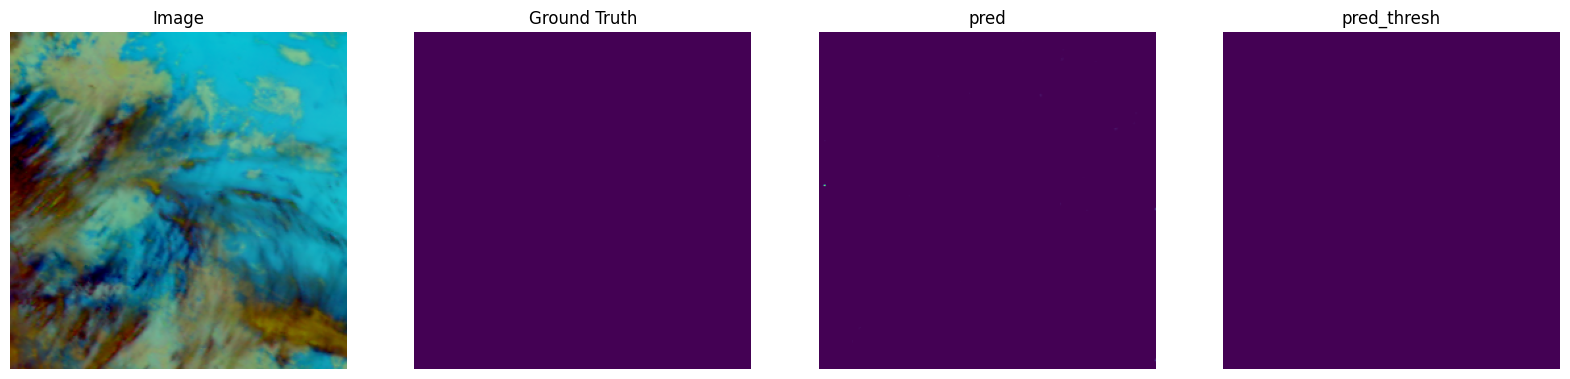

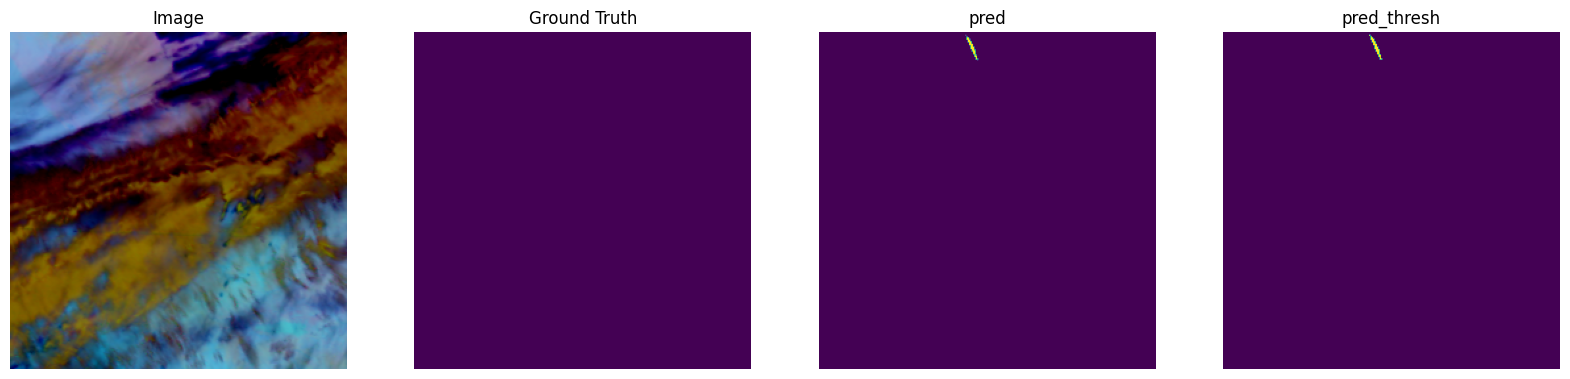

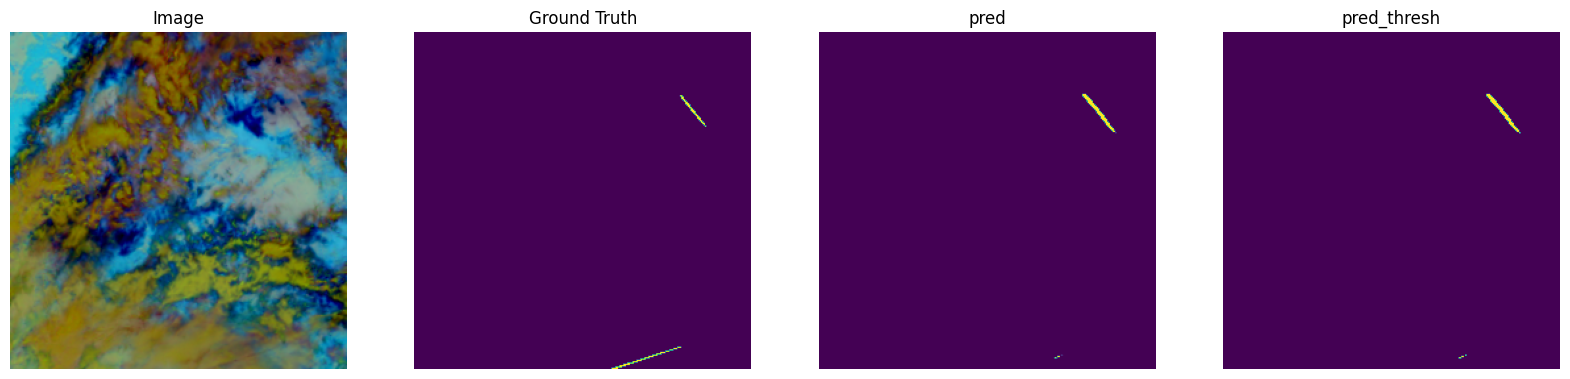

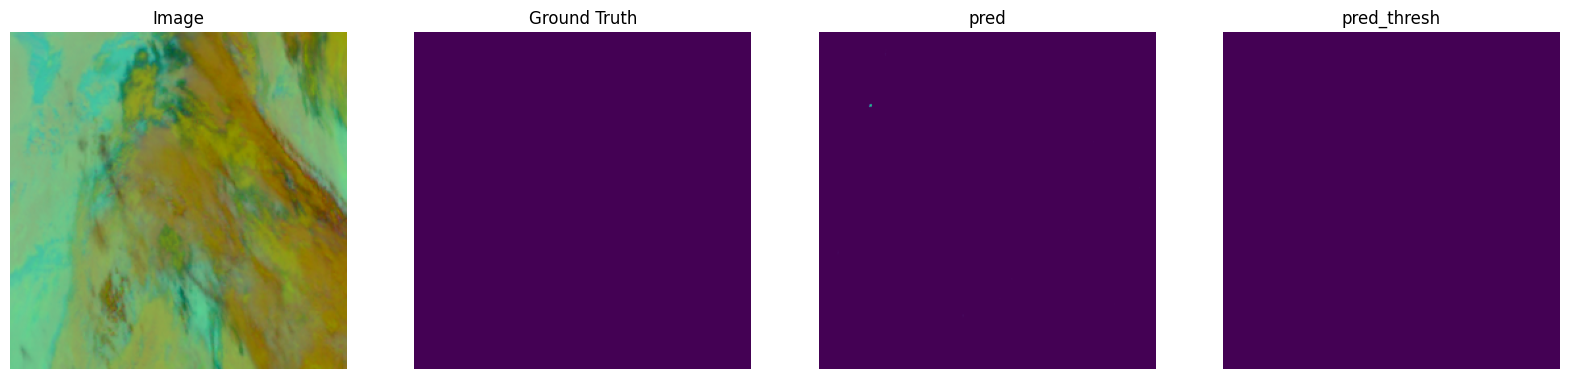

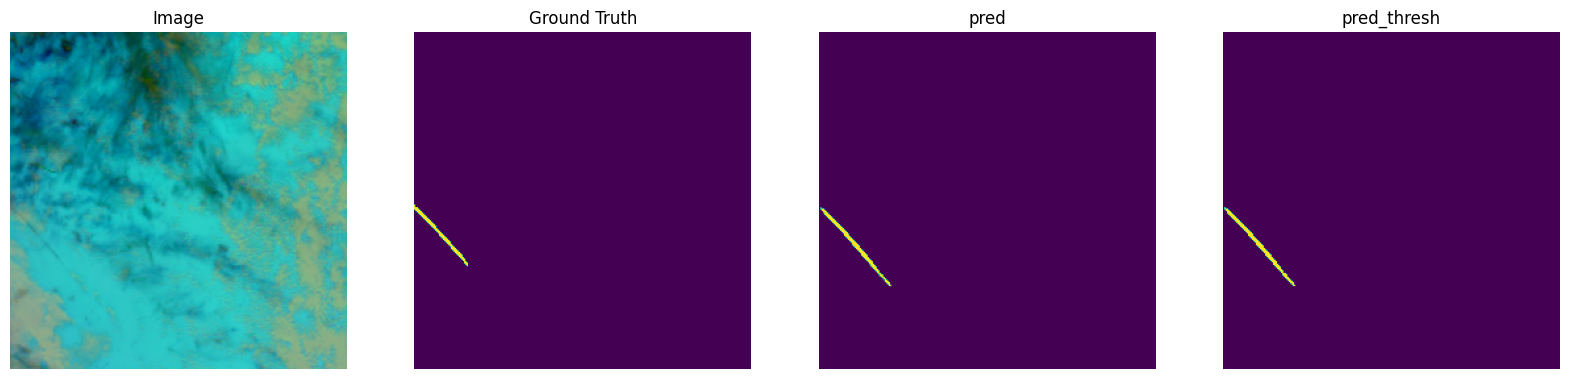

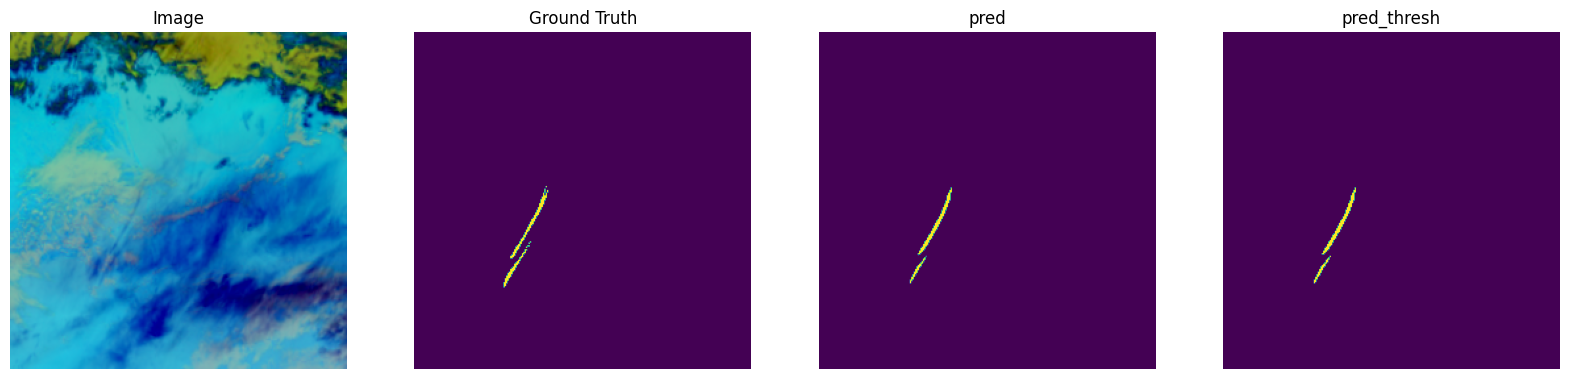

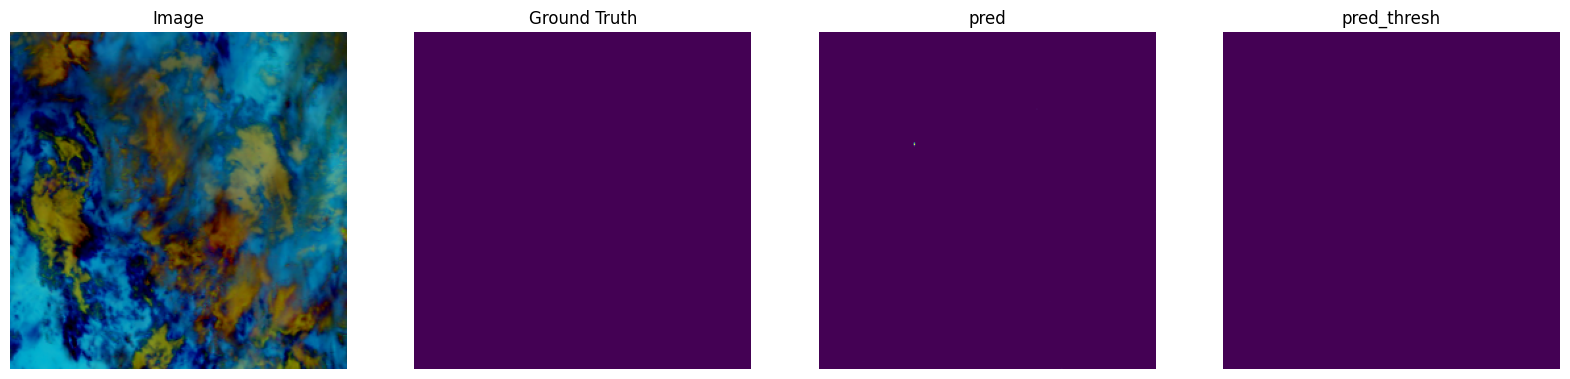

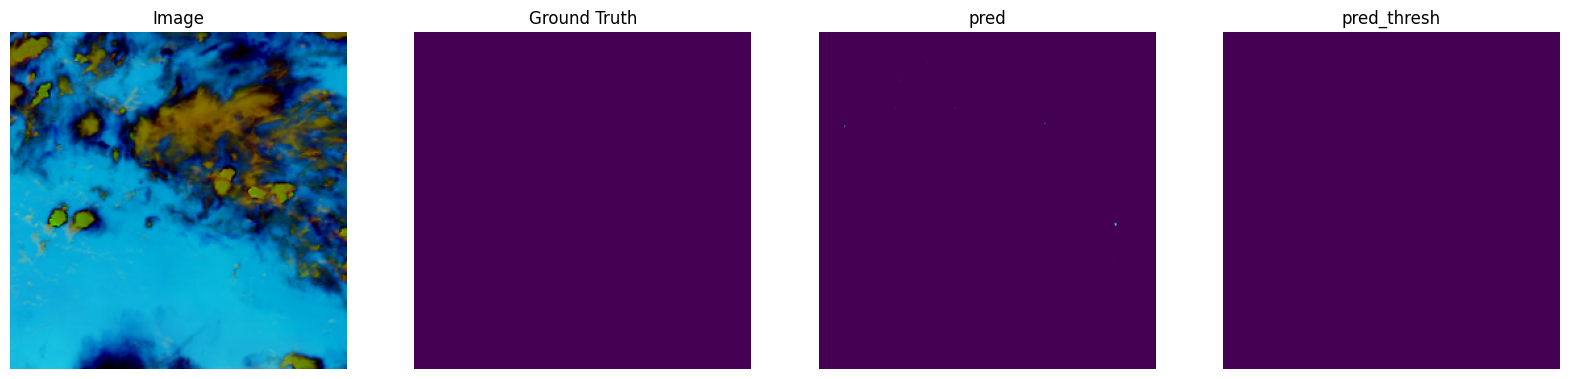

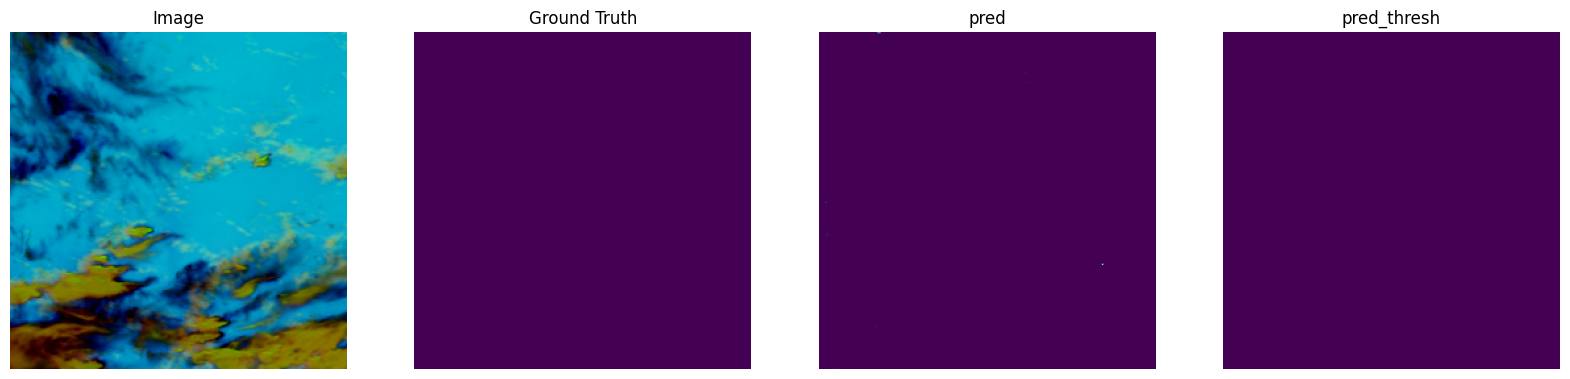

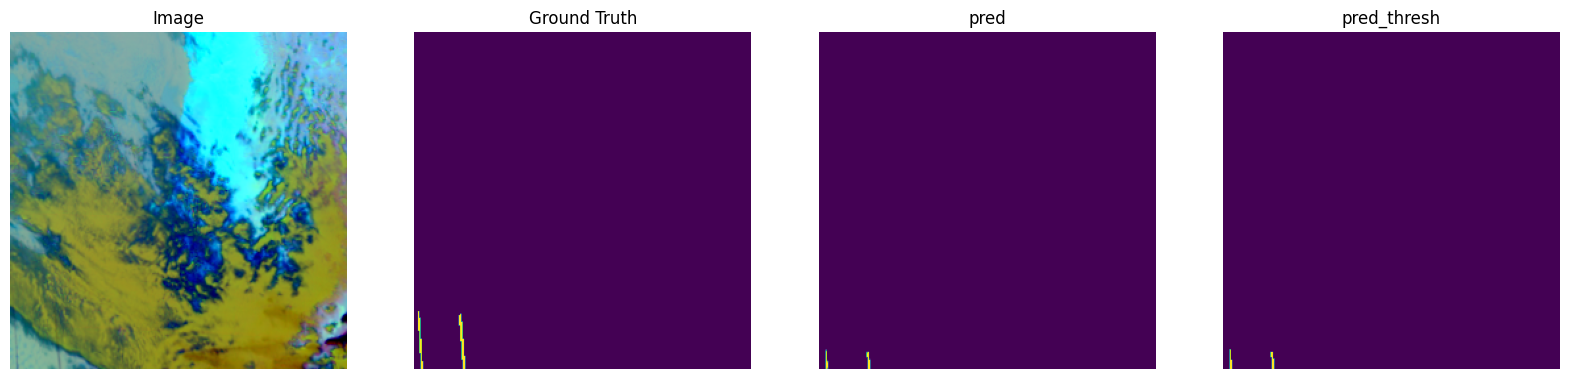

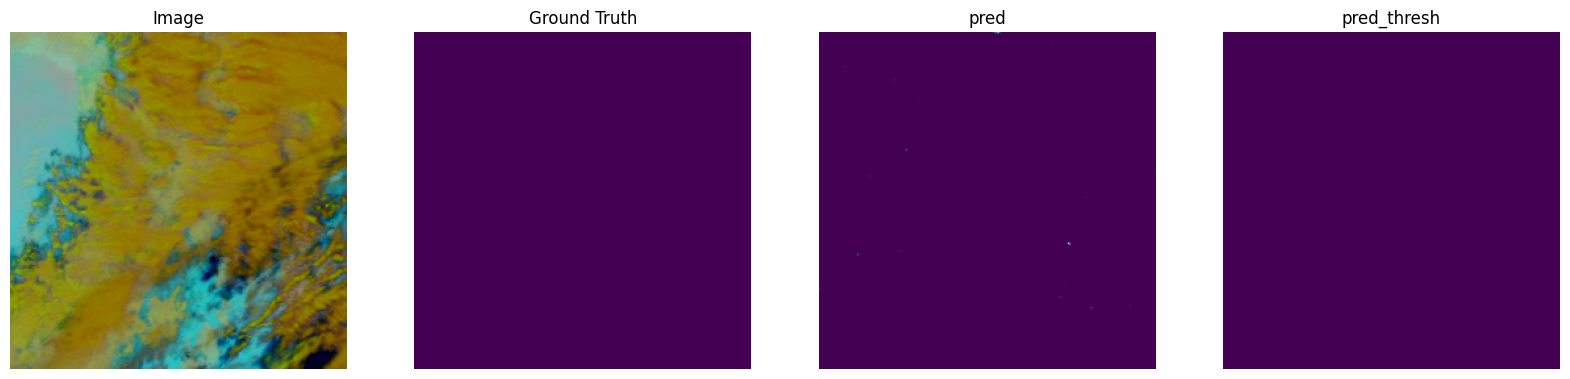

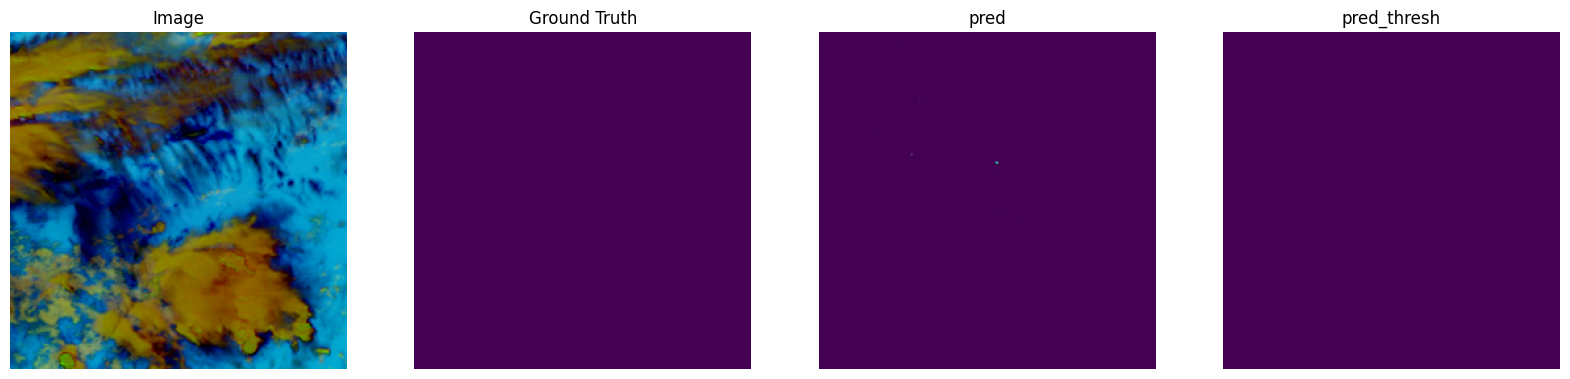

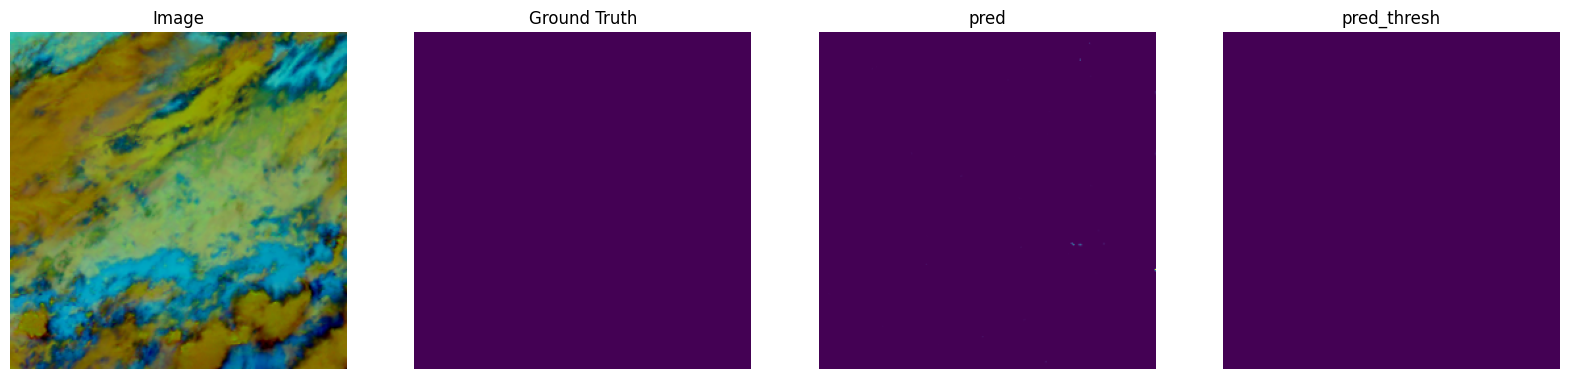

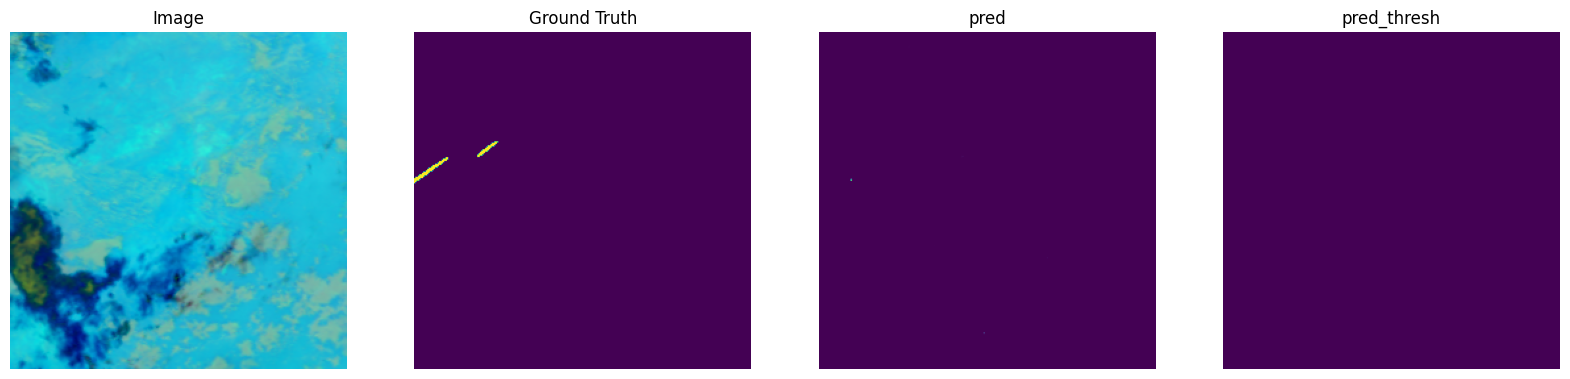

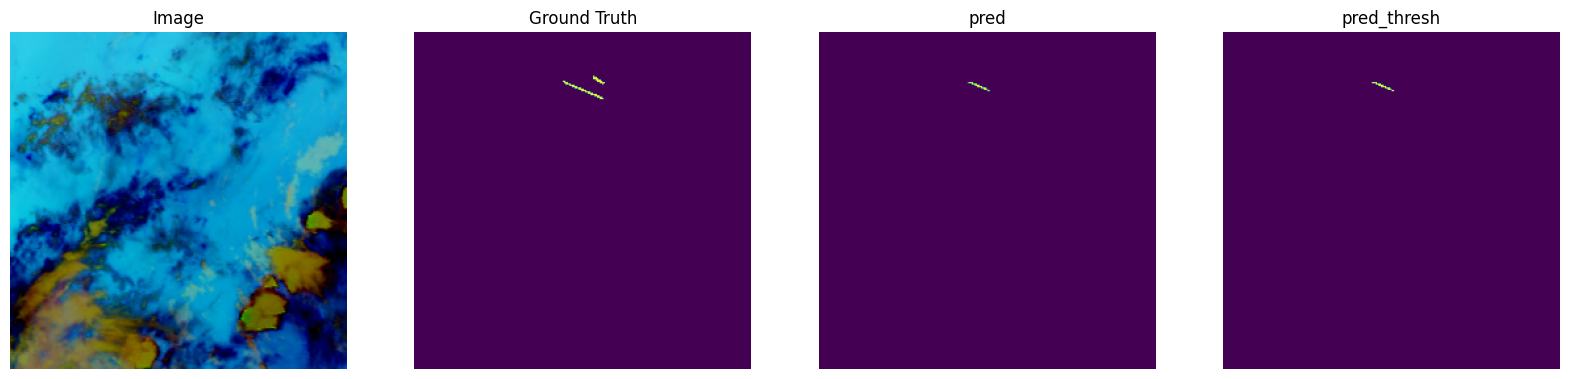

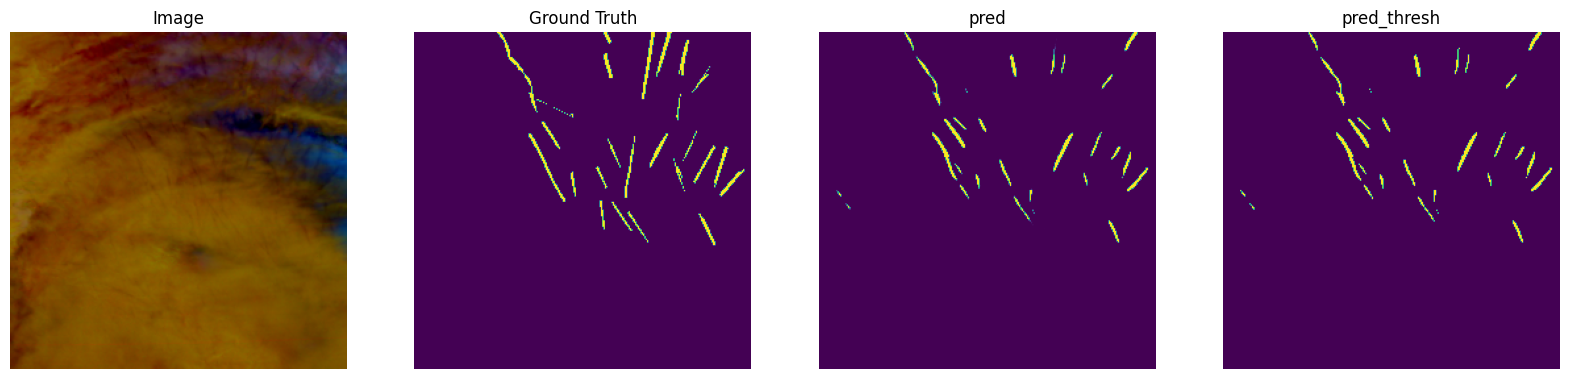

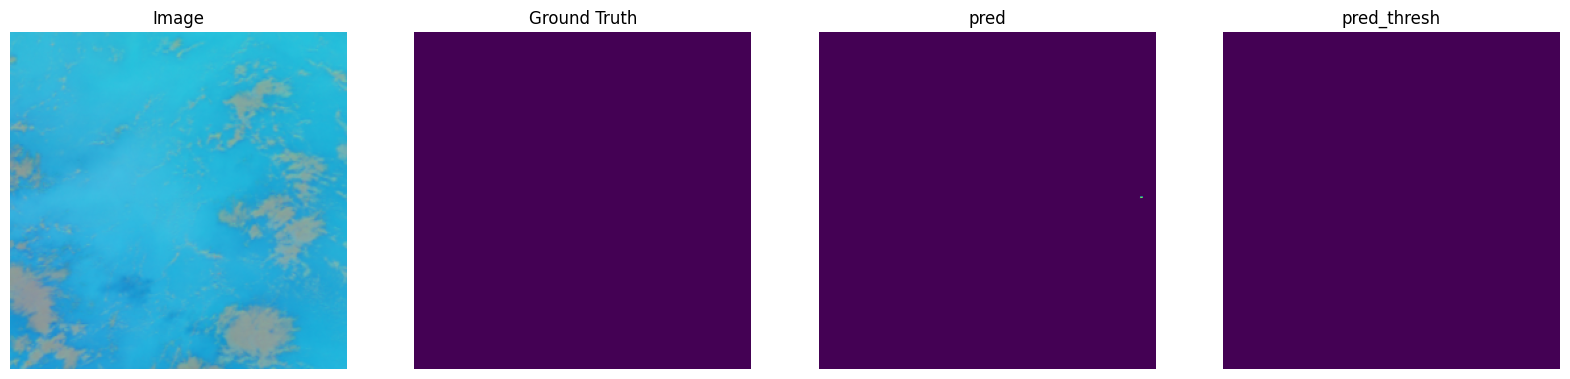

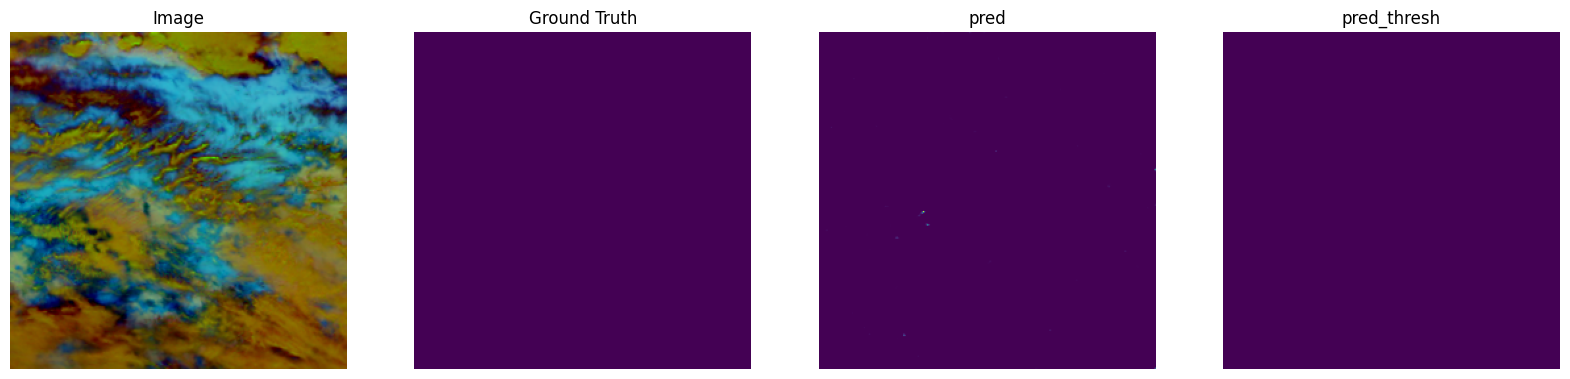

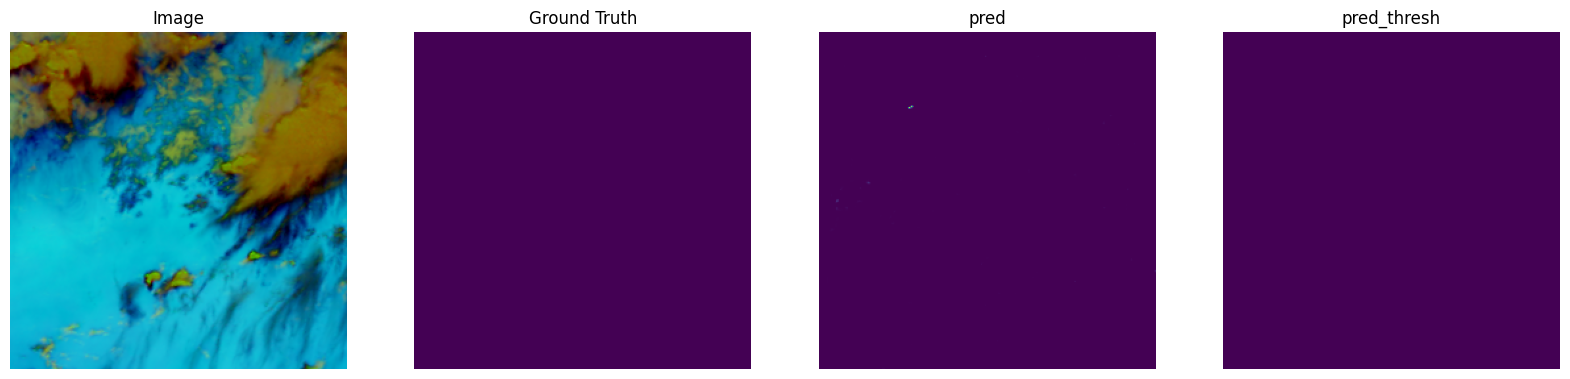

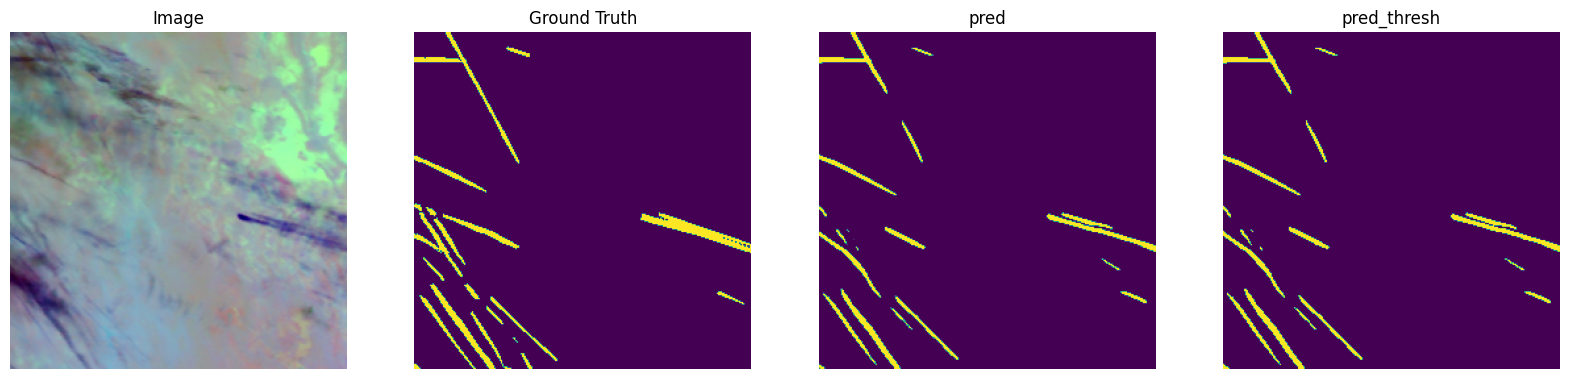

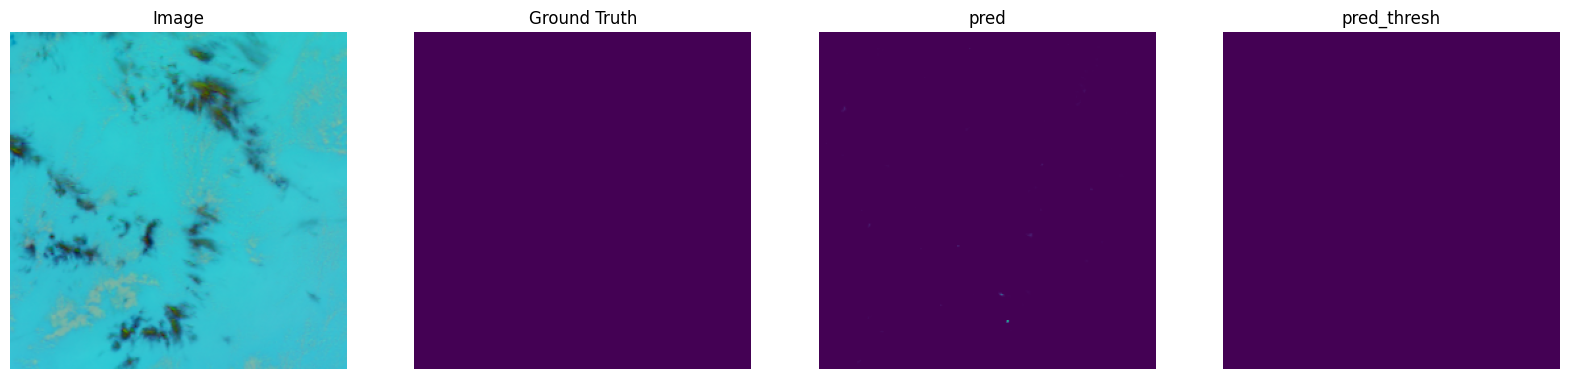

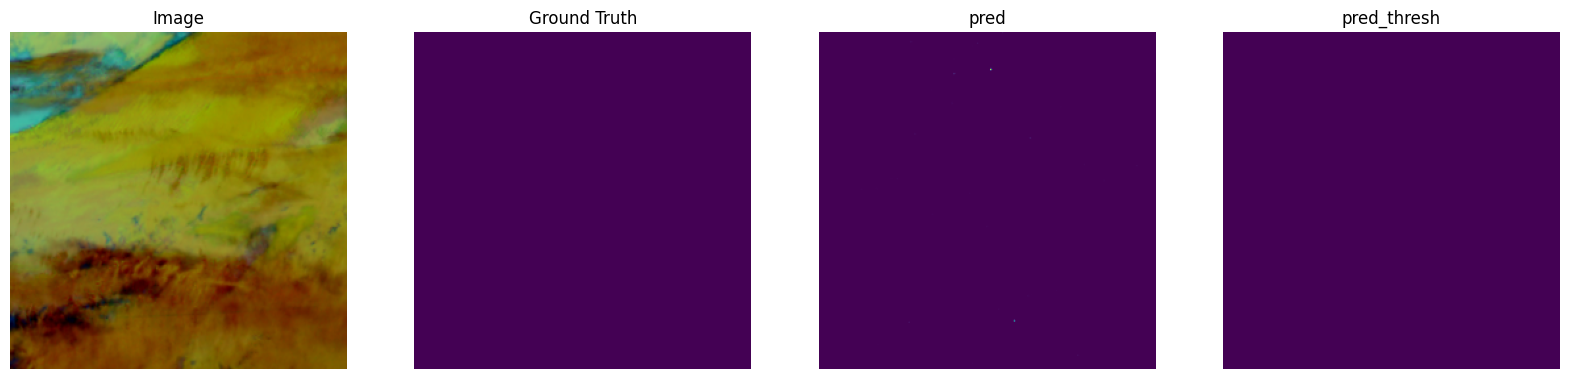

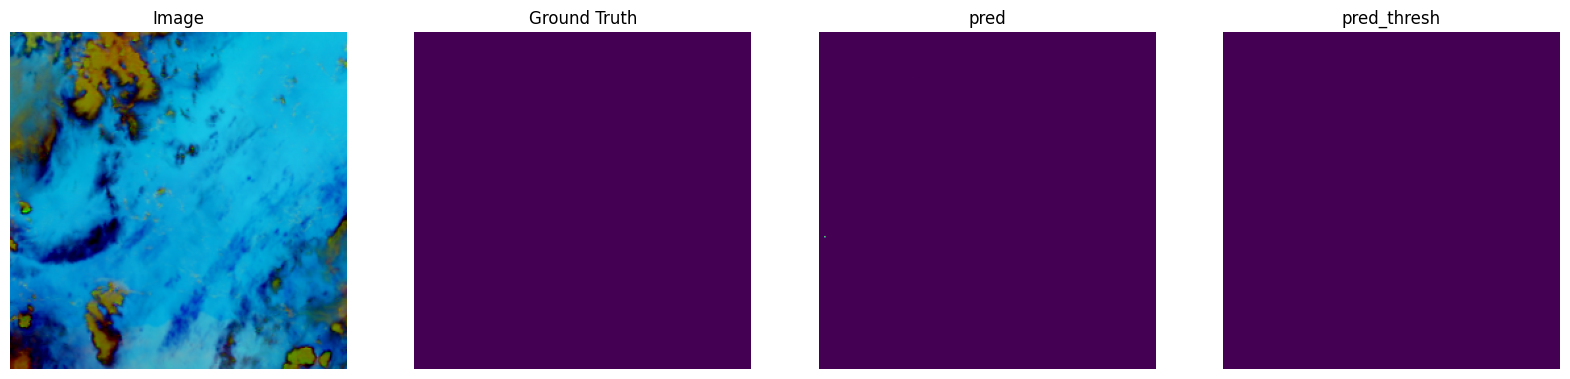

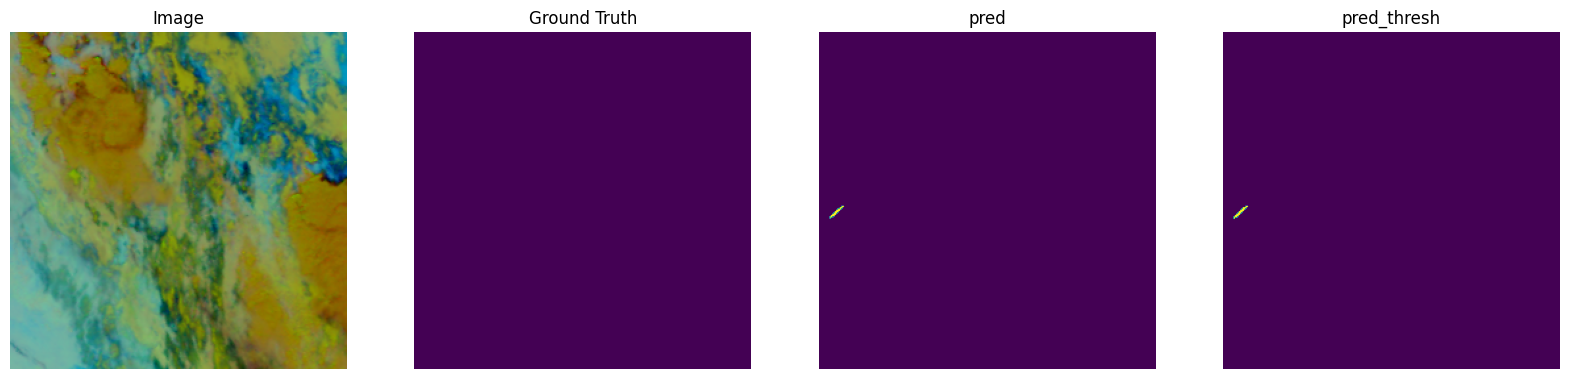

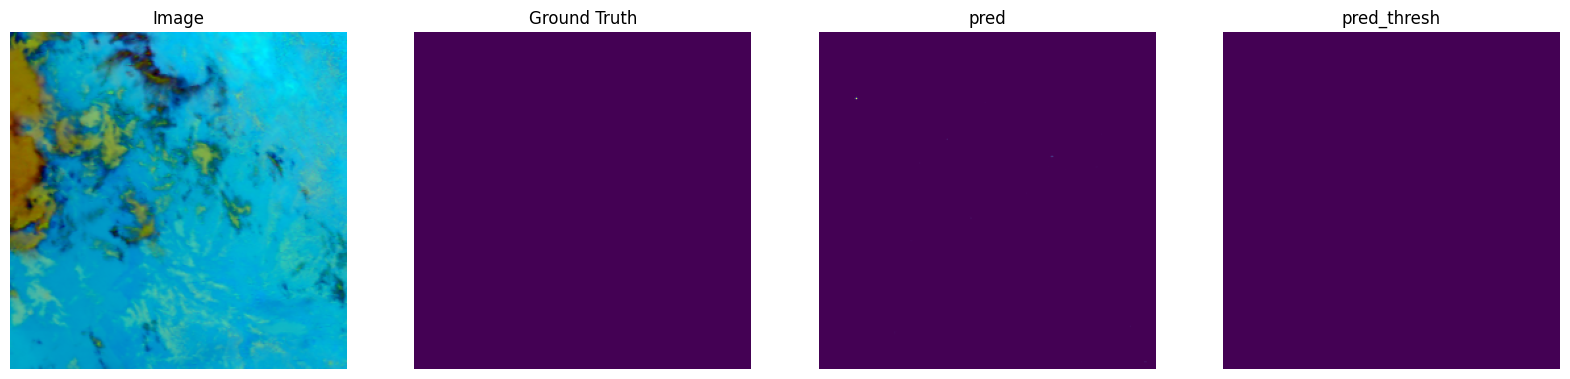

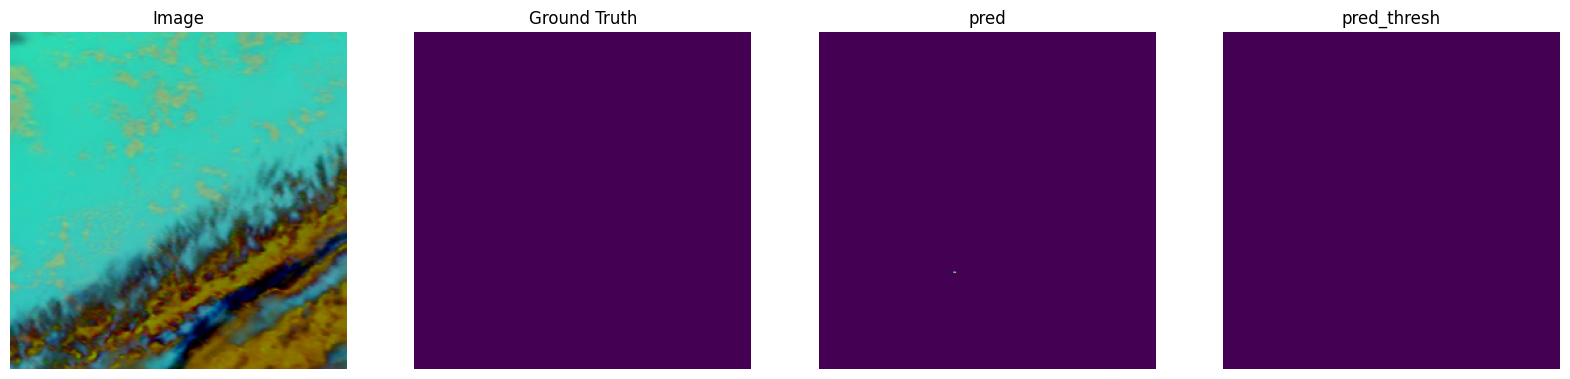

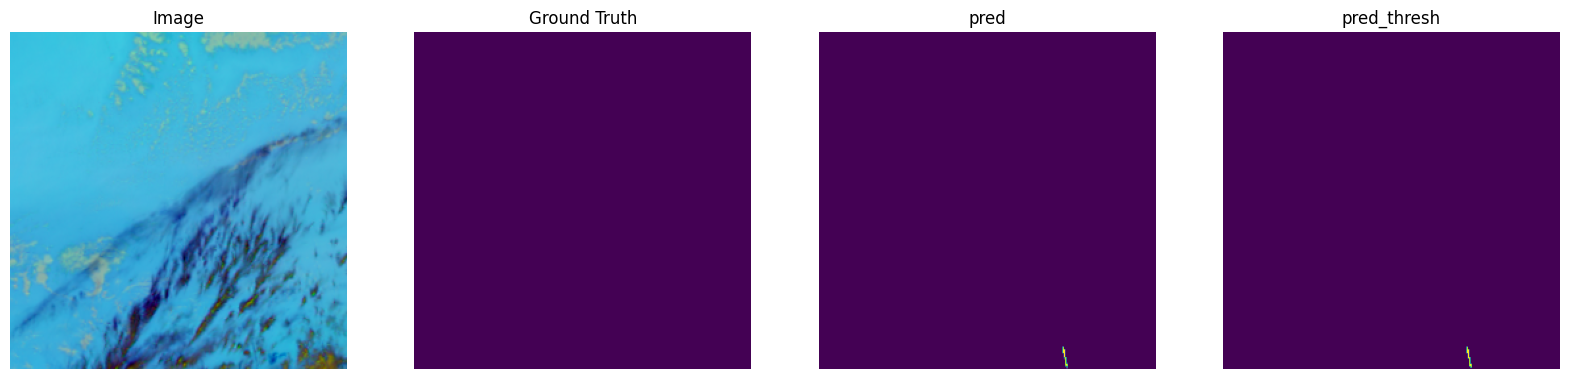

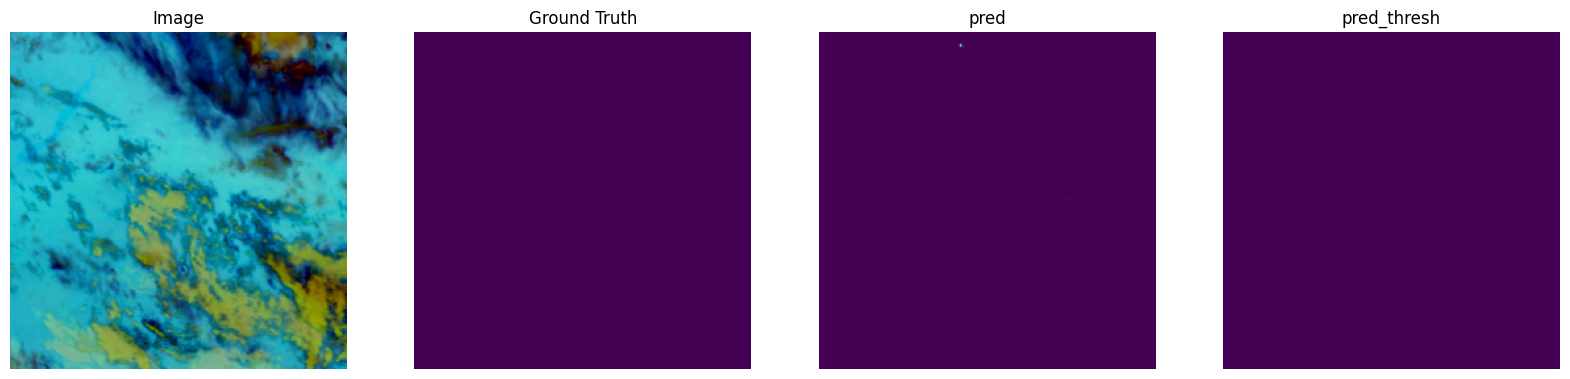

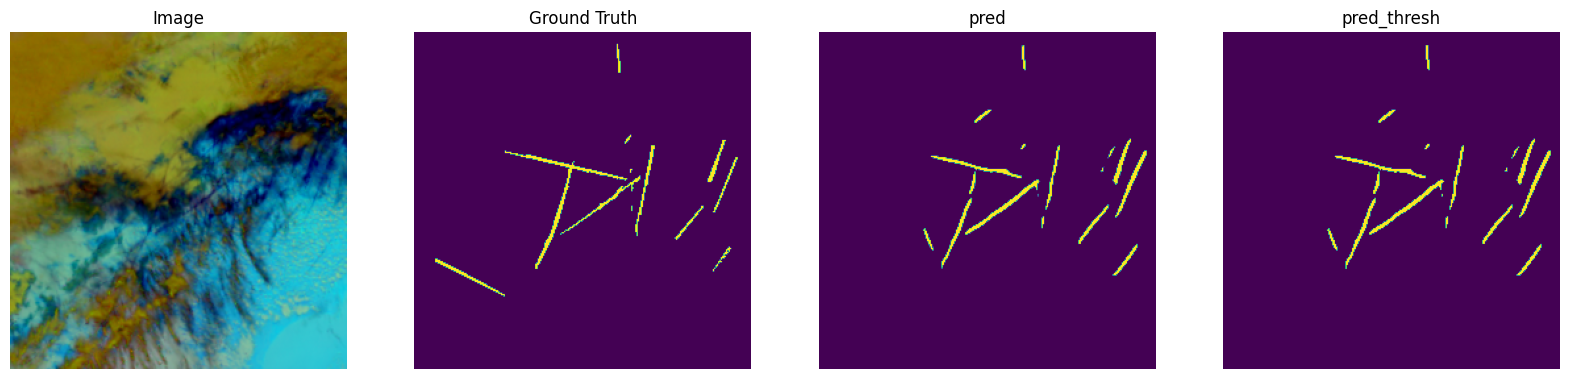

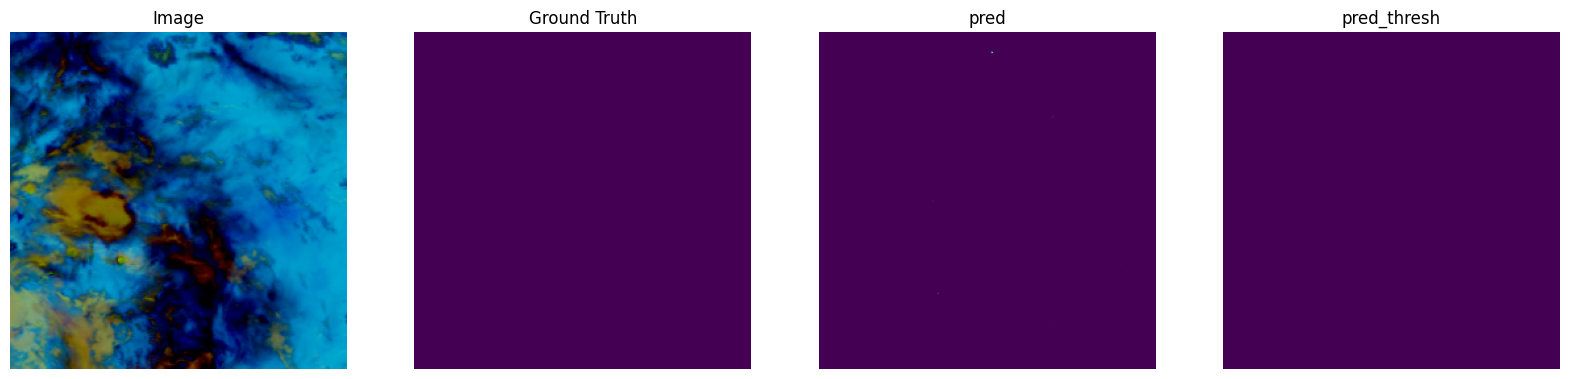

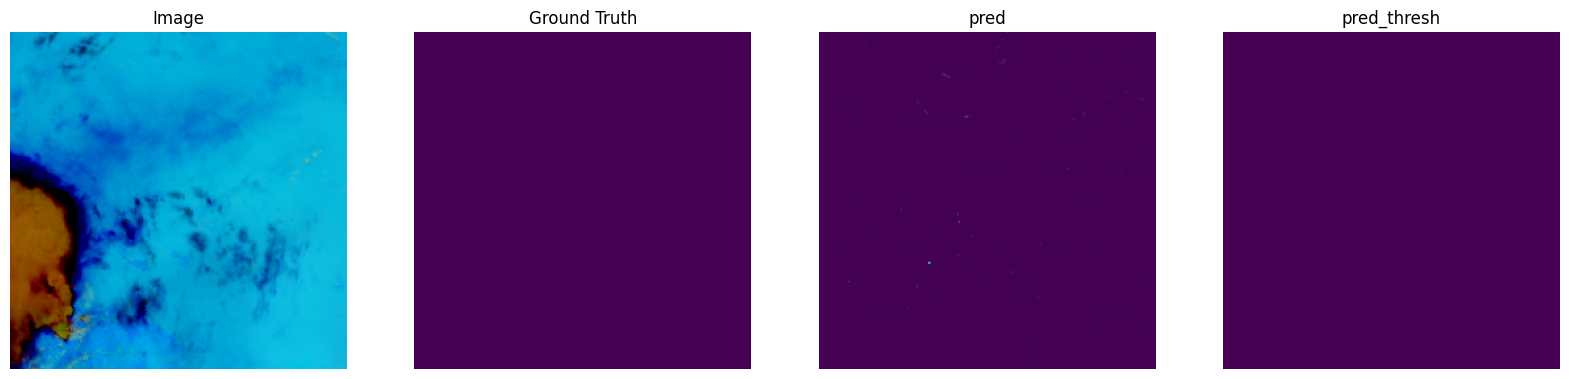

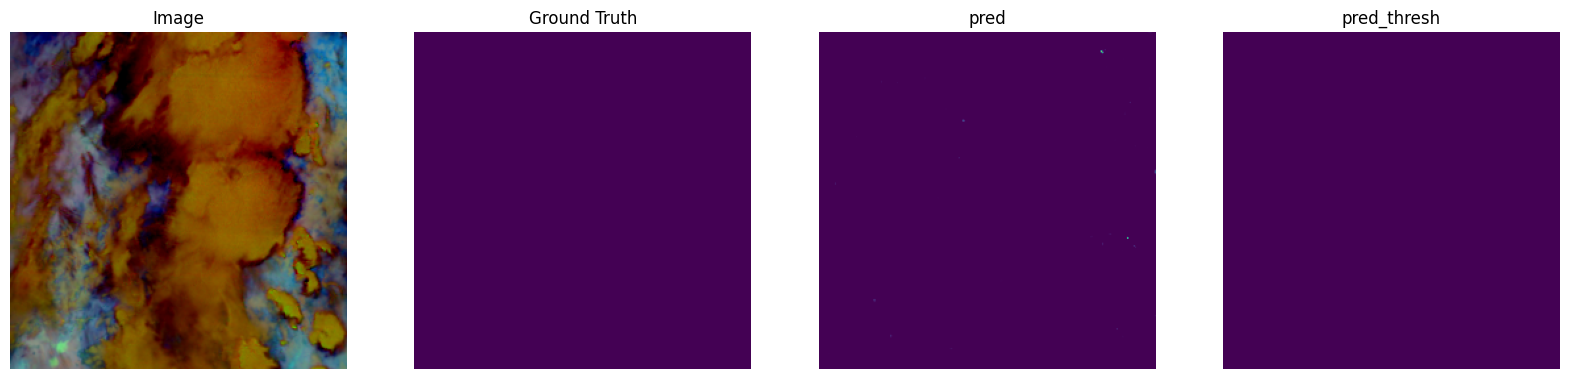

In [10]:
for i, (images, masks) in enumerate(dataloader_valid):
    if i!=1: continue
    
    images, masks = images.cuda(), masks.cuda()
    with torch.no_grad():
        preds = model(images)
        preds = torch.sigmoid(preds)
    images, masks, preds = images.cpu(), masks.cpu(), preds.cpu()
    
    for num in range(CFG.valid_batch_size):
        fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20,5))
        axes = axes.flatten()
        axes[0].imshow(images[num].permute(1,2,0))
        axes[0].axis('off')
        axes[0].set_title('Image')
        axes[1].imshow(masks[num].permute(1,2,0))
        axes[1].axis('off')
        axes[1].set_title('Ground Truth')
        axes[2].imshow(preds[num].permute(1,2,0))
        axes[2].axis('off')
        axes[2].set_title('pred')
        axes[3].imshow((preds[num]>thresh).permute(1,2,0))
        axes[3].axis('off')
        axes[3].set_title('pred_thresh')
    break